In [1]:
import urllib
import PIL
from IPython.display import Image

Assign appropriate image name: ensure unique one to prvent overwriting

In [2]:
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQIDs-ncXBnArX7FtJTw4e-EAGRPczf7azsSj_yoZuyUq4odvBJrw&s"

split_image_url = image_url.split(':')  # ['https', '//encrypted-tbn0.gstatic.com/images?q=tbn', 'ANd9GcQIDs-ncXBnArX7FtJTw4e-EAGRPczf7azsSj_yoZuyUq4odvBJrw&s']

image_name = split_image_url[-1]  # 'ANd9GcQIDs-ncXBnArX7FtJTw4e-EAGRPczf7azsSj_yoZuyUq4odvBJrw&s'

image_name = image_name.replace("-", "_")  # ANd9GcQIDs_ncXBnArX7FtJTw4e_EAGRPczf7azsSj_yoZuyUq4odvBJrw&s
image_name

'ANd9GcQIDs_ncXBnArX7FtJTw4e_EAGRPczf7azsSj_yoZuyUq4odvBJrw&s'

Get image from url

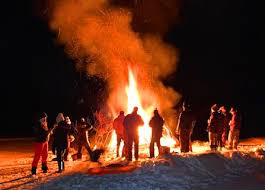

In [3]:
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdnj9LWjxtSqw_3sVxBDOE9Sym1oL5LLXBkDhB10BfU-Tf7MpXbA&s"
image_name = "sample.png"

urllib.request.urlretrieve(image_url, image_name)

img = PIL.Image.open("sample.png")
display(img)

Parse urllib response to check if it's an image, for exception handling in the pipeline

In [4]:
with urllib.request.urlopen(image_url) as response:
    # check if URL contains an image
    info = response.info()
    
info

In [5]:
info.get_content_type()

'image/jpeg'

In [6]:
type(info.get_content_type())

str

Helper function to stitch everything together

Credit: The following is a slight modification of the original one [here](https://stackoverflow.com/questions/25412119/uploading-an-image-from-an-external-link-to-google-cloud-storage-using-google-ap/25417071).

In [9]:
from google.cloud import storage
import urllib.request

def upload_image_from_url_to_google_storage(
                                            img_url,
                                            BUCKET_NAME,
                                            BUCKET_FILE_PATH
                                           ):
    """
    Uploads an image from a URL source to google storage.
    Args:
        img_url: string URL of the image e.g. https://picsum.photos/200/200
    """
    
    # Get appropriate/unique name for each image file to be stored
    split_image_url = image_url.split(':')
    image_name = split_image_url[-1]
    image_name = image_name.replace("-", "_")
    
    # separation of bucket name from blob name
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(BUCKET_NAME)
    blob = bucket.blob(BUCKET_FILE_PATH + "/" + image_name + ".jpg")

    # try to read the image URL
    try:
        print(f'Getting image from: {img_url}')
        with urllib.request.urlopen(img_url) as response:
            
            # check if URL contains an image
            info = response.info()
            if (info.get_content_type().startswith("image")):  # e.g. 'image/jpeg'
                blob.upload_from_string(response.read(), 
                                        content_type=info.get_content_type())
                print("Uploaded image from: " + img_url)
            else:
                print("Could not upload image. No image data type in URL")

    except urllib.error.HTTPError as exception:
        print(f'Could not upload image from {img_url}. Error message: {exception}')

In [10]:
BUCKET_NAME = "fire_detection_anurag" # <-- change this
BUCKET_FILE_PATH = "test_images" # <-- change this

upload_image_from_url_to_google_storage(
                                        image_url,
                                        BUCKET_NAME,
                                        BUCKET_FILE_PATH
                                       )

Getting image from: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdnj9LWjxtSqw_3sVxBDOE9Sym1oL5LLXBkDhB10BfU-Tf7MpXbA&s
Uploaded image from: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSdnj9LWjxtSqw_3sVxBDOE9Sym1oL5LLXBkDhB10BfU-Tf7MpXbA&s


Next step: Build a Dataflow pipeline to do this at scale.